# Lightshow X-ray absorption spectroscopy broadening

Example: Ti k-edge anatase XAS 

Broadening equation:
Gaussian function: $G(x ; \sigma) \equiv \frac{e^{-x^{2} /\left(2 \sigma^{2}\right)}}{\sigma \sqrt{2 \pi}}$ ,

Lorentzian function: $L(x ; \Gamma) \equiv \frac{\frac{1}{2}\Gamma}{\pi\left(x^{2}+(\frac{1}{2}\Gamma)^{2}\right)}$,

Voigt function: $V(x ; \sigma, \Gamma) \equiv \int_{-\infty}^{\infty} G\left(x^{\prime} ; \sigma\right) L\left(x-x^{\prime} ; \Gamma\right) d x^{\prime}$ ,



Energy dependent function: using energy dependent Gamma value $\Gamma\left(E\right)=\Gamma_0+\alpha\ (E-E_f)$ in Voigt function. In this script, the broadening parameter sigma $\sigma$ and lorentz divider $\frac{1}{\alpha}$ are optimized comparaing to exprimental spectrum.


Hebert, C., Practical aspects of running the WIEN2k code for electron spectroscopy. Micron, 2007. 38(1): p. 12-28.

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

So the paths work:

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

In [4]:
from lightshow.postprocess.broaden import SiteSpectum

## Using manual parameters to broaden the XAS simulation

Anatase TiO$_2$ experimental data is derived from Yan _et al_. [Ultrathin amorphous titania on nanowires: Optimization of conformal growth and elucidation of atomic-scale motifs.](https://doi.org/10.1021/acs.nanolett.8b04888) Nano Lett. **19**, 3457 (2019).

In [5]:
# Some information we'll need for the energy-dependent Voigt broadening
TiK_core_state = -4864.0371       
TiK_core_hole_lifetime = 0.89
ana_core_hole_fermi_energy = 5.1302
e_fermi = ana_core_hole_fermi_energy - TiK_core_state 

In [6]:
# Experimental data
experimental_spectrum = np.loadtxt('spectra_files/anatase_exp.txt')

# Anatase TiO2 theoretical simulation is calculated by VASP
vasp_data_loaded = np.loadtxt('spectra_files/anatase_theory_VASP.txt')
vasp_spectrum = SiteSpectum(vasp_data_loaded.copy(), e_fermi=e_fermi)

# Align this data to experiment
vasp_spectrum.align_to_experiment_(experimental_spectrum)
vasp_spectrum.scale_max_to_1_()

# Example of broadening the vasp spectrum with Gaussian broadening and sigma=1
x = np.linspace(4900, 5100, 1000)
vasp_spectrum_G_broadened = vasp_spectrum.broaden(x, method="Gaussian", sigma=1.0)

# ... using Lorentzian broadening
vasp_spectrum_L_broadened = vasp_spectrum.broaden(x, method="Lorentzian", gamma=1.0)

# ... using Voigt broadening
vasp_spectrum_V_broadened = vasp_spectrum.broaden(x, method="Voigt", sigma=0.5, gamma=0.5)

# ... using energy-dependent Voigt broadening
vasp_spectrum_EDV_broadened = vasp_spectrum.broaden(
    x,
    method="energy_dependent_voigt_broaden",
    sigma=0.2,
    ld=40.0,
    lt=TiK_core_hole_lifetime
)

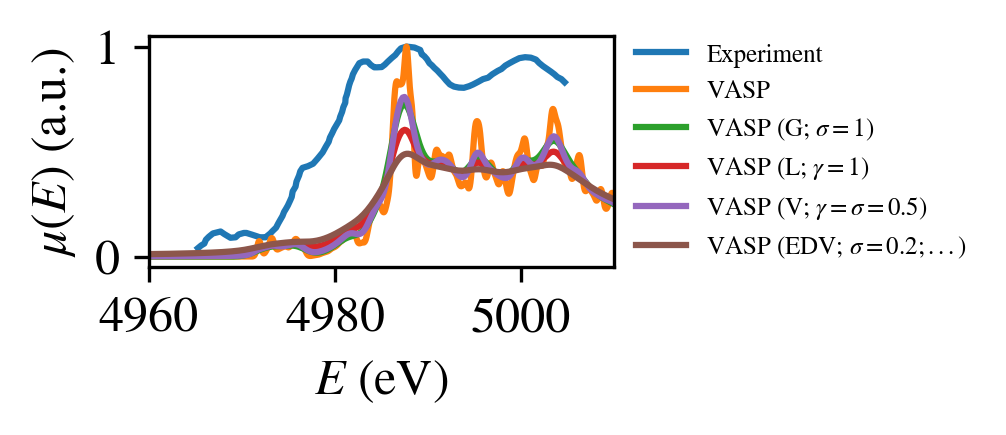

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1))

ax.plot(experimental_spectrum[:, 0], experimental_spectrum[:, 1], label='Experiment')
ax.plot(vasp_spectrum.spectrum[:, 0], vasp_spectrum.spectrum[:, 1], label='VASP')
ax.plot(x, vasp_spectrum_G_broadened, label=r'VASP (G; $\sigma=1$)')
ax.plot(x, vasp_spectrum_L_broadened, label=r'VASP (L; $\gamma=1$)')
ax.plot(x, vasp_spectrum_V_broadened, label=r'VASP (V; $\gamma=\sigma=0.5$)')
ax.plot(x, vasp_spectrum_EDV_broadened, label=r'VASP (EDV; $\sigma=0.2;...$)')


ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left", fontsize=6)
ax.set_ylabel("$\mu(E)$ (a.u.)")
ax.set_xlabel("$E$ (eV)")
ax.set_xlim(4960, 5010)

plt.show()

There are some issues here:
1. The broadening parameter is not necessarily correct.
2. Even after doing the align-by-maxima procedure, the spectra are clearly not aligned (look at the edge locations).

## Optimal broadening parameters

In [8]:
# BELOW IS WRONG SOMEHOW!
# It also takes a looong time!!

In [17]:
bounds = [
    (-5, 2), # shift
    (0.1, 4),  # sigma
]

In [18]:
res = vasp_spectrum.optimize_parameters(experimental_spectrum, method="Gaussian", bounds=bounds)

In [19]:
res

     fun: -0.9821440915008767
    funl: array([-0.98214409])
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
   nlfev: 57
   nlhev: 0
   nljev: 13
 success: True
       x: array([-3.98389216,  3.92306424])
      xl: array([[-3.98389216,  3.92306424]])

In [20]:
optimized_broadened = vasp_spectrum.broaden(
    x,
    "Gaussian",
    *res.x[1:]
)

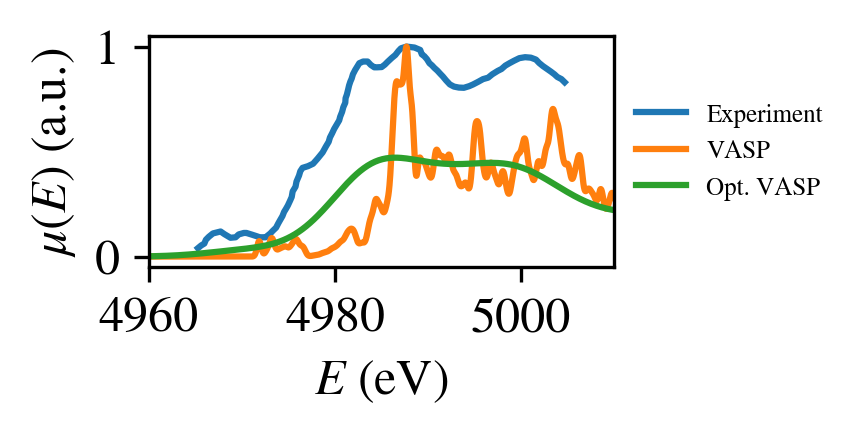

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1))

ax.plot(experimental_spectrum[:, 0], experimental_spectrum[:, 1], label='Experiment')
ax.plot(vasp_spectrum.spectrum[:, 0], vasp_spectrum.spectrum[:, 1], label="VASP")
ax.plot(x + res.x[0], optimized_broadened, label='Opt. VASP')


ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left", fontsize=6)
ax.set_ylabel("$\mu(E)$ (a.u.)")
ax.set_xlabel("$E$ (eV)")
ax.set_xlim(4960, 5010)

plt.show()